In [1]:
from datetime import timedelta

import cartopy.crs as ccrs # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import pandas as pd # type: ignore
import xarray as xa # type: ignore

proj_nps = ccrs.NorthPolarStereo()
proj_pc = ccrs.PlateCarree()

In [2]:
ifile = '/Data/sat/downloads/CS2/LARM2/uit_cryosat2_L2_alongtrack_2020_01.txt'
df = pd.read_csv(ifile)
col_mapper = {i:i.strip().replace('#', 'no') for i in df.columns}
df.rename(mapper=col_mapper, axis=1, inplace=True)
print(df.columns)

Index(['SAR=0_SARIN=1', 'Orbit_no', 'Segment_no', 'Datenumber', 'Latitude',
       'Longitude', 'Radar_Freeboard', 'Surface_Height_WGS84',
       'Sea_Surface_Height_Interp_WGS84', 'SSH_Uncertainty',
       'Mean_Sea_Surface', 'SLA', 'Sea_Ice_Class', 'Lead_Class',
       'Sea_Ice_Roughness', 'Sea_Ice_Concentration'],
      dtype='object')


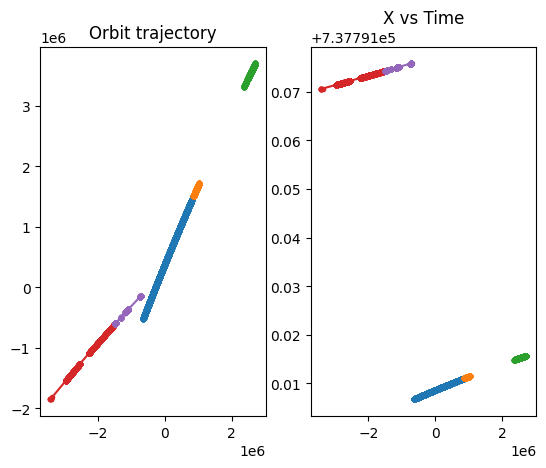

In [3]:
# The individual orbits in the field Orbit_# seem to be too short
fig, axs = plt.subplots(1, 2)

for i in [1, 2, 3, 4, 5]:
    subdf = df[(df['Orbit_no'] == i)]
    x, y, _ = proj_nps.transform_points(proj_pc, subdf['Longitude'], subdf['Latitude']).T
    axs[0].plot(x, y, '.-')
    axs[0].set_title('Orbit trajectory')
    axs[1].plot(x, subdf['Datenumber'], '.-')
    axs[1].set_title('X vs Time')
plt.show()

In [4]:
# Creating new orbit#
# find difference between observations in seconds
date_diff_sec = df['Datenumber'].diff().to_numpy()*60*60*24
# find indices of obs. where time difference is more than 1000 sec (one orbit is ~5000 sec)
orbit_starts_ends = np.hstack([0, np.nonzero(date_diff_sec > 1000)[0], date_diff_sec.size + 1])
# loop over indices and creacte correct orbit_no
orbit_no = np.zeros(date_diff_sec.size)
for i, (orbit_start, orbit_end) in enumerate(zip(orbit_starts_ends[:-1], orbit_starts_ends[1:])):
    orbit_no[orbit_start:orbit_end] = i
df['orbit_no'] = orbit_no

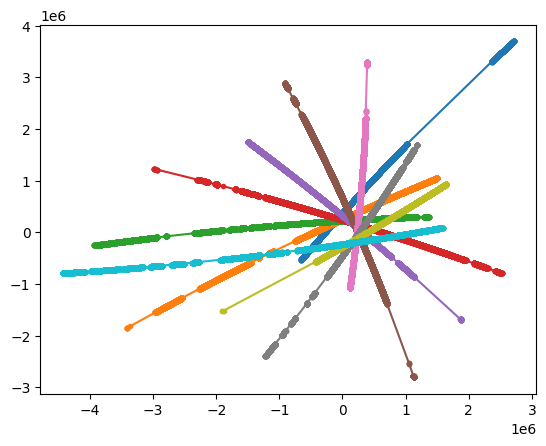

In [5]:
# Plot several orbits for testing
for i in range(10):
    subdf = df[(df['orbit_no'] == i)]
    x, y, _ = proj_nps.transform_points(proj_pc, subdf['Longitude'], subdf['Latitude']).T
    plt.plot(x, y, '.-')
plt.show()


In [14]:
def convert_time_index(datenumber):
    """ Convert the floating point Datenumber to pandas.DateTimeIndex"""
    ordinal0 = int(datenumber.iloc[0])
    # NB! Matlab datenum is offset by 366 days...
    date0 = pd.Timestamp.fromordinal(ordinal0) - timedelta(days = 366)
    deltas = datenumber - ordinal0
    date_time_index = date0 + pd.to_timedelta(deltas * 60 * 60 * 24, 's')
    return pd.DatetimeIndex(date_time_index)

In [17]:
# create DateTimeIndex for the entire DataFrame
df.index = convert_time_index(df['Datenumber']).rename('Datetime')

In [18]:
# save as netCDF for further use
xds = xa.Dataset.from_dataframe(df)
xds.to_netcdf(ifile.replace('.txt', '.nc'))